In [118]:
import blackjack
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Часть первая, с блекджеком и стратегиями

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остал/ьных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [186]:
# Используем класс по ссылке задания - https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
env = blackjack.BlackjackEnv(natural=True)

In [122]:
# Усредняем награду по n эпизодам
n = 100000
rewards = []
for i in range(n):
    obs = env.reset()
    while(True):
        if (obs[0] >= 19) and (obs[0] <= 21):
            obs, reward, done, _ = env.step(0)
        else:
            obs, reward, done, _ = env.step(1)
        if done:
            break
    rewards.append(reward)
np.mean(rewards)

-0.176285

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym

In [158]:
class Q_learning():
    # epsilon-greedy Q learning
    
    def __init__(self, env, alpha=0.1, gamma=1, eps=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.q = np.zeros(([d.n for d in env.observation_space] + [env.action_space.n]))
        
        
    def get_action(self, obs, train=True):
        # switch to greedy when we don't need exploration
        if train:
            # epsilon-greedy
            if np.random.rand() < self.eps:
                # random action
                action = np.random.randint(0, self.env.action_space.n)
            else:
                # use policy (action with the highest q(s, a))
                q_s  = q[obs[0], obs[1], int(obs[2])] # get action q's for given state, n = action_space
                action = np.argmax(q_s)
            return action
        else:
            # greedy
            q_s  = q[obs[0], obs[1], int(obs[2])] # get action q's for given state, n = action_space
            action = np.argmax(q_s)
            return action


    def train(self, steps, steps_to_validate, validation_episodes=100000):
        obs = env.reset()
        self.validation_rewards = []
        for i in tqdm(range(steps)):
            action = self.get_action(obs)
            # performing the action
            obs_next, reward, done, _ = env.step(action)
            q[obs[0], obs[1], int(obs[2]), action] = (1 - self.alpha) * q[obs[0], obs[1], int(obs[2]), action] +\
                self.alpha * (reward + self.gamma * np.max(q[obs_next[0], obs_next[1], int(obs_next[2])]))
            if done:
                obs = env.reset()
            else:
                obs = obs_next
            if ((i + 1) % steps_to_validate==0 and i!=0):
                mean_reward = self.validate(validation_episodes)
                self.validation_rewards.append(mean_reward)
        print('Training done')
        return self.validation_rewards
        
    def validate(self, episodes):
        rewards = []
        for i in range(episodes):
            obs = env.reset()
            while(True):
                action = self.get_action(obs, train=False)
                obs, reward, done, _ = env.step(action)
                if done:
                    break
            rewards.append(reward)
        return np.mean(rewards)

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [159]:
env = blackjack.BlackjackEnv(natural=True)

In [171]:
q_learing = Q_learning(env, alpha=0.9, eps=0.2)

In [176]:
results = q_learing.train(int(5e6), int(5e5), int(1e5))

100%|██████████| 5000000/5000000 [05:58<00:00, 13930.55it/s]

Training done


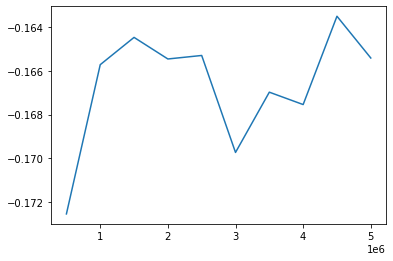

In [177]:
plt.plot([(i+1)*5e5 for i in range(len(results))], results)

In [187]:
print(f'С учетом относительно оптимальных гиперпараметров казино в среднем выигрывает {q_learing.validate(int(1e6))} ставок')

С учетом относительно оптимальных гиперпараметров казино в среднем выигрывает -0.1663965 ставок


# Часть вторая, удвоенная

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.


In [188]:
# см. blackjack.py - добавлено третье действие в новый класс
env = blackjack.BlackjackDoubleEnv(natural=True)

In [190]:
env.action_space

Discrete(3)

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.